Import all necessary libraries. These can be installed with ```poetry install --no-root```.

In [52]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

Create the dataset class that allows for easy manipulation of the training data

In [30]:
class Dataset:
    def __init__(self, path):
        self.images, self.truths = torch.load(path)
        # Normalize the pixel values
        self.images = self.images / 255.
        self.truths = F.one_hot(self.truths, num_classes=10).to(float)

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.images[idx], self.truths[idx]

Use the dataset class to create a dataloader for the training data

In [37]:
train_dl = DataLoader(Dataset(path), batch_size=5)

12000

Feed forward multi layer perception (MLP)

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(28**2, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 10)

    def forward(self, x):
        # Turn the image matrix into a single vector
        x = x.view(-1, 28**2)

        # Feed the vector through the MLP
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        return x


**Training Loop**

This takes the training data loader and trains the model with the following pseudocode:

```
1. Read in batch data
2. Feed image matrices through MLP
3. Perform cross entropy loss relative to the ground truths
4. Repeat steps 1-3 for n epochs
```

In [53]:
def train_model(data_loader, network, n_epochs=1):
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
    loss_f = nn.CrossEntropyLoss()

    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")

        N = len(data_loader)
        for idx, (images, truths) in enumerate(data_loader):
            prediction = network(images)
            loss = loss_f(prediction, truths)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            epochs.append(epoch + idx/N)

    return np.array(epochs), np.array(losses)

Create the feed forward MLP and train the model.

In [ ]:
mlp = MLP()
epochs, losses = train_model(train_dl, mlp)

Reshape the data to be the average of each epoch and then plot it.

Text(0.5, 1.0, 'Losses per Epoch')

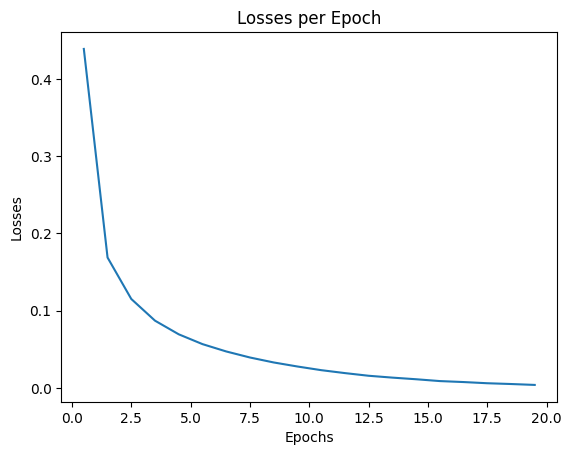

In [97]:
epochs_avg = epochs.reshape(20, -1).mean(axis=1)
losses_avg = losses.reshape(20, -1).mean(axis=1)
plt.plot(epochs_avg, losses_avg)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Losses per Epoch")

Load the testing data and get the predicted values from the MLP.

In [57]:
path = "./MNIST/processed/test.pt"

test_data = Dataset(path)
test_images, test_truths = test_data[:2000]
predicted_vals = mlp(test_images).argmax(axis=1)

Plot some of the images and their corresponding guesses.

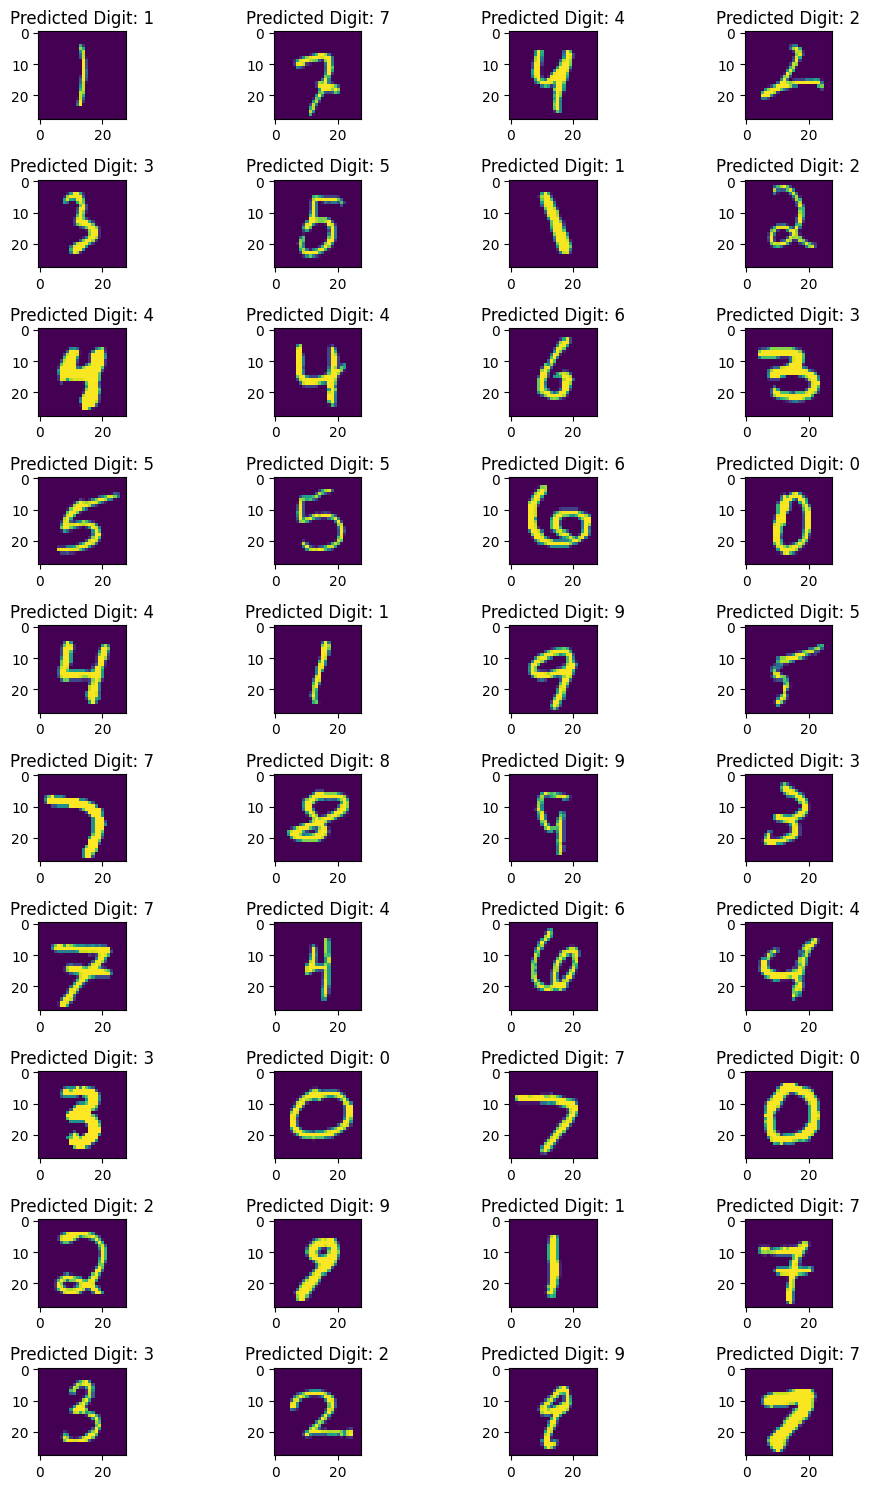

In [61]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(test_images[i])
    plt.title(f'Predicted Digit: {predicted_vals[i]}')
fig.tight_layout()
plt.show()

Compare the accuracy of the model on the test data

In [62]:
test_truths

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [95]:
correct = 0
total = len(predicted_vals)

incorrect_idxs = []
idx = 0
for predicted_val, truth in zip(predicted_vals, test_truths):
    truth = truth.argmax()

    if predicted_val.item() == truth.item():
        correct += 1
    else:
        incorrect_idxs.append(idx)

    idx += 1

print(f"The model got {correct} out of {total}. Accuracy: {correct/total * 100}%")



The model got 1945 out of 2000. Accuracy: 97.25%


**Incorrect Plot**

This shows all of the numbers that the model incorrectly guessed.

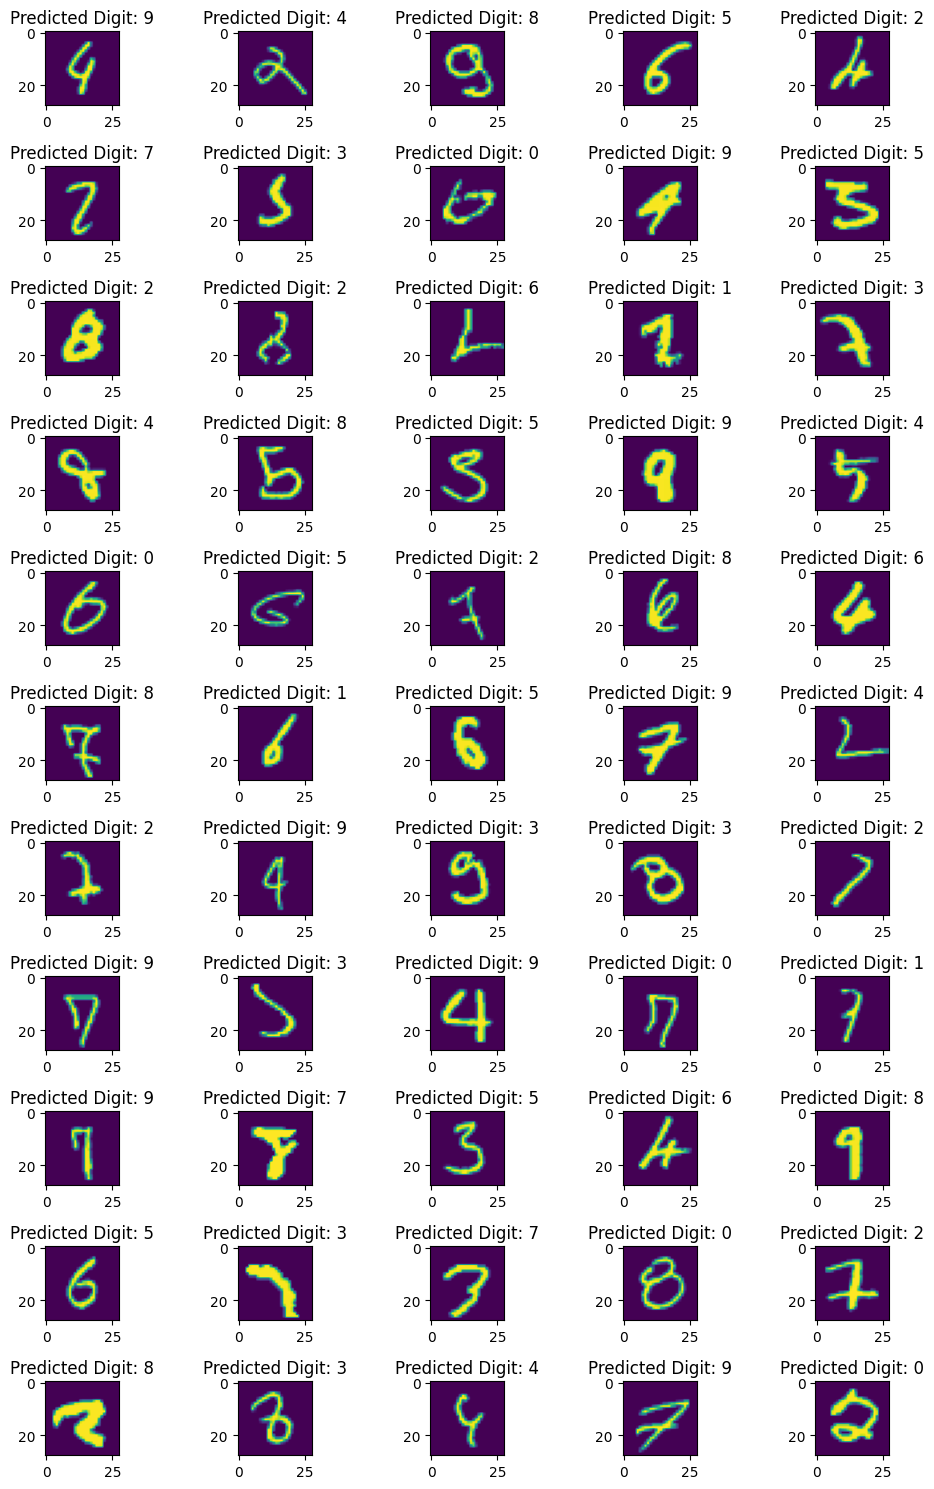

In [93]:
fig, ax = plt.subplots(11,5,figsize=(10,15))
for idx, incorrect_idx in enumerate(incorrect_idxs):
    plt.subplot(11,5,idx+1)
    plt.imshow(test_images[incorrect_idx])
    plt.title(f'Predicted Digit: {predicted_vals[incorrect_idx]}')
fig.tight_layout()
plt.show()